# Section 5: Homework Exercises

This material provides some hands-on experience using the methods learned from the third day's material.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.stats as st
import pymc3 as pm
import theano.tensor as tt
import arviz as az
import io

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Exercise 1

Consider a data set from "Statistics: A Bayesian Perspective", by Don Berry (1995). The dataset describes the outcome of professional golfers putting from a number of distances:

In [2]:
# golf putting data from berry (1996)
golf_data = """distance tries successes
2 1443 1346
3 694 577
4 455 337
5 353 208
6 272 149
7 256 136
8 240 111
9 217 69
10 200 67
11 237 75
12 202 52
13 192 46
14 174 54
15 167 28
16 201 27
17 195 31
18 191 33
19 147 20
20 152 24"""


golf_data = pd.read_csv(io.StringIO(golf_data), sep=" ")

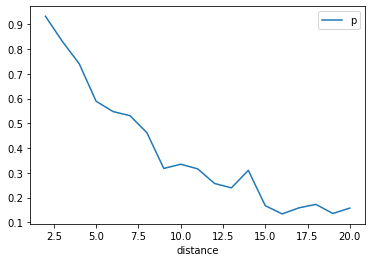

In [3]:
golf_data.assign(p=golf_data.successes/golf_data.tries).plot('distance', 'p');

Use a latent GP to estimate the probability of success according to distance.

In [4]:
with pm.Model() as golf_model:

    length_scale = pm.Exponential('length_scale', 0.5)
    amplitude = pm.Exponential('amplitude', 0.5)

    K = amplitude**2 * pm.gp.cov.ExpQuad(1, length_scale)
    gp = pm.gp.Latent(cov_func=K)
    f = gp.prior('f', X=golf_data.distance.values.reshape(-1, 1))

    # Transform latent gp to probability scale
    p = pm.Deterministic('p', pm.math.invlogit(f))

    y = pm.Binomial('y', n=golf_data.tries.values, p=p, observed=golf_data.successes.values)

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '9889' (I am process '9919')


In [5]:
with golf_model:

    approx = pm.fit(10000, method='fullrank_advi')
    trace = approx.sample(1000)

Finished [100%]: Average Loss = 100.69


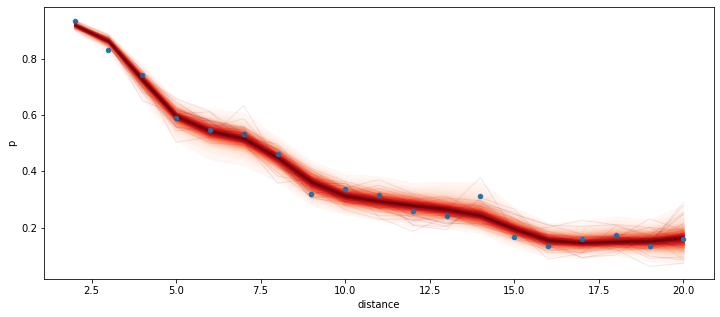

In [6]:
from pymc3.gp.util import plot_gp_dist

fig = plt.figure(figsize=(12,5)); ax = fig.gca()
plot_gp_dist(ax, trace["p"], golf_data.distance.values)
golf_data.assign(p=golf_data.successes/golf_data.tries).plot.scatter('distance', 'p', ax=ax);

## Exercise 2: Nashville daily temperatures

The file `TNNASHVI.txt` in your data directory contains daily temperature readings for Nashville, courtesy of the [Average Daily Temperature Archive](http://academic.udayton.edu/kissock/http/Weather/). This data, as one would expect, oscillates annually. Use a Gaussian process to fit a regression model to this data.

In [7]:
daily_temps = pd.read_table("../data/TNNASHVI.txt", sep='\s+', 
                            names=['month','day','year','temp'], na_values=-99)

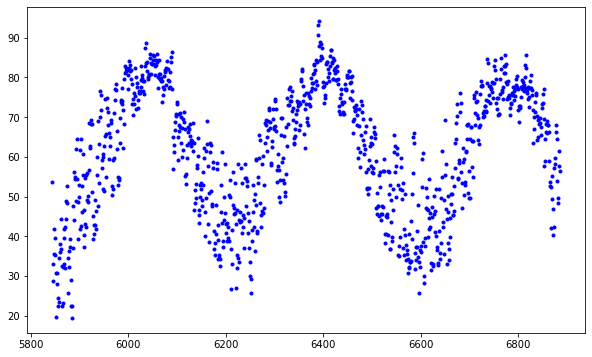

In [8]:
temps_2010 = daily_temps.temp[daily_temps.year>2010]
temps_2010.plot(style='b.', figsize=(10,6), grid=False)

In [9]:
y = temps_2010.values
x = temps_2010.index.values
X = (x - x.min()).reshape(-1, 1)

In [10]:
with pm.Model() as rainfall_model:

    length_scale = pm.Exponential('length_scale', 0.5)
    amplitude = pm.Exponential('amplitude', 0.5)

    K = amplitude**2 * pm.gp.cov.ExpQuad(1, length_scale)
    gp = pm.gp.MarginalSparse(cov_func=K, approx="FITC")

    Xu = pm.gp.util.kmeans_inducing_points(15, X)

    s = pm.HalfCauchy("s", beta=5)
    y_ = gp.marginal_likelihood("y", X=X, Xu=Xu, y=y, noise=s)

In [11]:
with rainfall_model:

    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [s, amplitude, length_scale]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 197 seconds.


In [12]:
X_new = np.linspace(0, X.max(), num=100).reshape(-1,1)

In [13]:
with rainfall_model:
    f_pred = gp.conditional("f_pred", X_new)

    pred_samples = pm.sample_posterior_predictive(trace, vars=[f_pred], samples=1000)

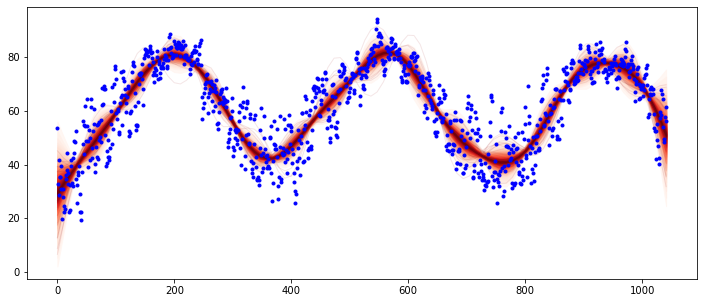

In [14]:
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
plot_gp_dist(ax, pred_samples["f_pred"], X_new)
temps_2010.index = X.flatten()
temps_2010.plot(style='b.', ax=ax);

Notice that we did not have to use a periodic kernel to model this periodic data! Remember the exponential quadratic is a **universal** kernel.